# Performance analysis of BERT for feature extraction

## Eclipse project

| Parameter     | Value         |
| ------------- |:-------------:|
| Model         | bert-base-uncase |
| Tokens        | 128     |
| Threshold     | median      |


In [1]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border: 1px solid lightgray;
    }
</style>

In [2]:
import sys 

import matplotlib
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
warnings.filterwarnings("ignore",category=UserWarning)

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator, PercentFormatter)

import numpy as np 
import pandas  as pd
import seaborn as sns
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

print("Python version:\n{}\n".format(sys.version))
print("matplotlib version: {}".format(matplotlib.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))
print('setup completed')

%matplotlib inline

Python version:
3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]

matplotlib version: 3.3.3
pandas version: 1.2.0
numpy version: 1.19.2
seaborn version: 0.11.1
setup completed


In [3]:
def set_style():
    """Setting the plot style."""
    sns.set_context("paper")
    sns.set_style("ticks", {
        "font.family": "sans-serif",
        "font.serif": ["Helvetica"]
    })
    
def set_size(fig):
    """Setting the plot size."""
    fig.set_size_inches(8, 4)
    plt.tight_layout()
    
def set_labels(size=12, ylabel=""):
    """Setting axis labels."""
    plt.xlabel("", fontsize=size)
    plt.xticks(fontsize=size)
    plt.ylabel(ylabel, fontsize=size)
    plt.yticks(fontsize=size)

def plot_box(metrics):
    fig, ax = plt.subplots()
    
    set_style()
    set_size(fig)
    
    properties = {
        'boxprops':{'facecolor':'white', 'edgecolor':'darkgray'},
        'medianprops':{'color':'darkgray'},
        'whiskerprops':{'color':'darkgray'},
        'capprops':{'color':'darkgray'}
    }
    
    sns.despine(offset=5)
    sns.boxplot(data=metrics, 
                x='classifier', 
                y='balanced_acc', 
                palette="Set2", 
                ax=ax, 
                **properties)
    
    set_labels(ylabel='Balanced accuracy\n(50 folds)')
    
    ax.set_ylim(0.4, .6)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    
    return fig, ax

def plot_bar(metrics, project):
    #fig, ax = plt.subplots()
    set_style()
    data_m  = metrics[(metrics.project == project)] 
    data_m  = metrics[['classifier', 'balanced_acc']].melt(id_vars=['classifier']) 
   
    #plt.figure(figsize=(10,10)) 
 
    data_m.sort_values('classifier').plot('classifier', 'value', label="Balanced Accuracy", kind="bar", legend=None, 
                color=['tab:blue', 'tab:pink', 'tab:green', 'tab:purple', 'tab:orange'],
                                         figsize=(9,5))
    sns.despine(offset=5)

    ax = plt.axes()
    
    for p in ax.patches:
        width  = p.get_width()
        height = p.get_height()
        x, y   = p.get_xy() 
        ax.annotate(f'{height:.1%}', (x + width/2, y + height*1.02), ha='center')

    set_labels(ylabel='Balanced accuracy')
    plt.ylim(0.2, 0.8)
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

    plt.title("{}".format(project))
    #plt.savefig(f"../output/figures/rq4e{experiment}-{project}-evaluation-all-classifiers.pdf", format="pdf", dpi=600, bbox_inch

def make_statistical_test(metrics_dataset):
    classifiers = ['knn', 'nb', 'nn', 'rf', 'svm']
    statistics  = pd.DataFrame(columns=['classifier1', 'mean1', 'classifier2', 'mean2', 'condition', 'direction'])
    alpha   = 0.05
    p       = 1.0
    for classifier1 in classifiers:
        sample1 = metrics_dataset.loc[:, (slice('balanced_acc'), classifier1)].values 
        mean1   = np.mean(sample1)
        for classifier2 in classifiers:
            sample2   = metrics_dataset.loc[:, (slice('balanced_acc'), classifier2)].values
            mean2     = np.mean(sample2)
            condition = True
            if (classifier1 != classifier2):
                stat, p   = wilcoxon(sample1.flatten(), sample2.flatten())
                condition = p > alpha
        
            statistics = statistics.append(
                {'classifier1': classifier1, 
                 'mean1': mean1, 
                 'classifier2': classifier2,
                 'mean2': mean2,
                 'condition': condition,
                 'direction': '$-$' if condition else '$\\leftarrow$' if mean1 > mean2 else '$\\uparrow$'}
                , ignore_index=True
            )
    return statistics

## Performance analysis in training

### Statistical measures

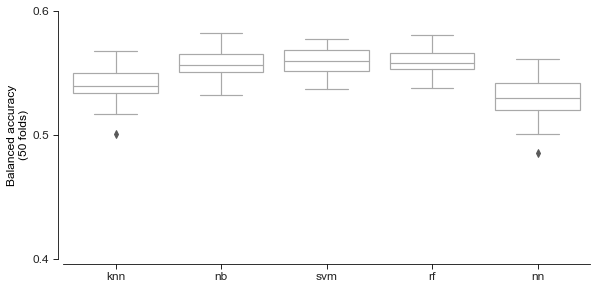

In [4]:
train_scores = pd.read_csv('../../../data/metrics/feature-extraction/20210210_eclipse_feature_extraction_bert_train_scores.csv')
_=plot_box(train_scores)

### Statistical test

In [5]:
train_scores_pivoted = pd.pivot_table (train_scores, index='fold', columns='classifier', values=['balanced_acc'])
train_scores_pivoted

balanced_acc                                        
classifier          knn        nb        nn        rf       svm
fold                                                           
0              0.533875  0.568239  0.534907  0.557332  0.564487
1              0.554764  0.558439  0.519963  0.547583  0.538309
2              0.535551  0.553604  0.537025  0.553903  0.560353
3              0.536377  0.551196  0.511381  0.577139  0.557880
4              0.539671  0.580871  0.543073  0.575298  0.577182
5              0.521790  0.558462  0.541722  0.557453  0.556937
6              0.565699  0.554185  0.510885  0.560949  0.552660
7              0.541754  0.557484  0.523465  0.571046  0.552960
8              0.537234  0.552029  0.538793  0.566216  0.552391
9              0.538956  0.550826  0.527192  0.553448  0.565557
10             0.518868  0.556308  0.522302  0.543811  0.564107
11             0.537677  0.565553  0.521204  0.558966  0.562182
12             0.544713  0.546272  0.534458  0.541309  0.548506
13             0.553580  0.553665  0.551755  0.558116  0.568625
14             0.540230  0.559287  0.529806  0.565066  0.575033
15             0.531512  0.544018  0.542025  0.561571  0.559085
16             0.524917  0.531891  0.501568  0.550021  0.539812
17             0.528295  0.564383  0.560703  0.566577  0.566774
18             0.553195  0.564029  0.537926  0.560777  0.571184
19             0.547331  0.582137  0.554596  0.605274  0.576918
20             0.533761  0.550927  0.519340  0.549845  0.550787
21             0.526053  0.549702  0.505166  0.537381  0.555525
22             0.550010  0.566011  0.529407  0.573633  0.562877
23             0.543467  0.552689  0.545405  0.548756  0.554689
24             0.526242  0.543778  0.543648  0.553883  0.559793
25             0.530326  0.569433  0.521531  0.555089  0.563249
26             0.549942  0.537650  0.546378  0.556207  0.553505
27             0.533407  0.558276  0.500156  0.548047  0.536443
28             0.553035  0.565265  0.525925  0.540779  0.549787
29             0.550625  0.553255  0.536431  0.580660  0.571267
30             0.534740  0.542071  0.523852  0.544022  0.537981
31             0.545808  0.556962  0.512388  0.558774  0.551309
32             0.546390  0.575516  0.519952  0.576642  0.577231
33             0.549210  0.570218  0.541670  0.564903  0.554141
34             0.534941  0.553876  0.521504  0.574415  0.550376
35             0.516461  0.545927  0.518756  0.558299  0.539807
36             0.538338  0.561503  0.549338  0.555143  0.565922
37             0.545549  0.571525  0.556530  0.570898  0.568488
38             0.553291  0.554557  0.519319  0.557883  0.570055
39             0.542697  0.565191  0.544608  0.563773  0.572456
40             0.551990  0.556359  0.518590  0.558953  0.564263
41             0.527088  0.554050  0.542709  0.559147  0.563909
42             0.567361  0.574481  0.523383  0.579589  0.574332
43             0.500727  0.544310  0.532287  0.541305  0.545496
44             0.537485  0.537190  0.484760  0.552549  0.556824
45             0.540531  0.535704  0.532719  0.555899  0.574165
46             0.551878  0.562547  0.527137  0.553830  0.554547
47             0.566008  0.567036  0.534240  0.541751  0.541094
48             0.525075  0.541018  0.529670  0.556746  0.544174
49             0.537463  0.573327  0.517291  0.571206  0.574433

In [6]:
statistical_test_results = make_statistical_test(train_scores_pivoted)
statistical_test_results

,classifier1,mean1,classifier2,mean2,condition,direction
0,knn,0.539918,knn,0.539918,True,$-$
1,knn,0.539918,nb,0.556865,False,$\uparrow$
2,knn,0.539918,nn,0.529377,False,$\leftarrow$
3,knn,0.539918,rf,0.559437,False,$\uparrow$
4,knn,0.539918,svm,0.558997,False,$\uparrow$
5,nb,0.556865,knn,0.539918,False,$\leftarrow$
6,nb,0.556865,nb,0.556865,True,$-$
7,nb,0.556865,nn,0.529377,False,$\leftarrow$
8,nb,0.556865,rf,0.559437,True,$-$
9,nb,0.556865,svm,0.558997,True,$-$


In [7]:
statistical_test_results_sliced = statistical_test_results[['classifier1', 'classifier2', 'direction']]
statistical_test_results_pivoted = statistical_test_results_sliced.pivot(index='classifier1', columns='classifier2', values='direction')
display(statistical_test_results_pivoted)

classifier2,knn,nb,nn,rf,svm
classifier1,,,,,
knn,$-$,$\uparrow$,$\leftarrow$,$\uparrow$,$\uparrow$
nb,$\leftarrow$,$-$,$\leftarrow$,$-$,$-$
nn,$\uparrow$,$\uparrow$,$-$,$\uparrow$,$\uparrow$
rf,$\leftarrow$,$-$,$\leftarrow$,$-$,$-$
svm,$\leftarrow$,$-$,$\leftarrow$,$-$,$-$


### Performance analysis in testing

#### BERT

In [8]:
test_scores_bert = pd.read_csv('../../../data/metrics/feature-extraction/20210210_eclipse_feature_extraction_bert_test_scores.csv')
test_scores_bert.head()

,project,classifier,train_class_0,train_class_1,test_class_0,test_class_1,acc,balanced_acc,feature_extraction
0,eclipse,knn,3616,3539,1206,1179,0.555136,0.555378,bert
1,eclipse,nb,3616,3539,1206,1179,0.560587,0.560863,bert
2,eclipse,svm,3616,3539,1206,1179,0.573585,0.573212,bert
3,eclipse,rf,3616,3539,1206,1179,0.582390,0.581729,bert
4,eclipse,nn,3616,3539,1206,1179,0.561426,0.561274,bert


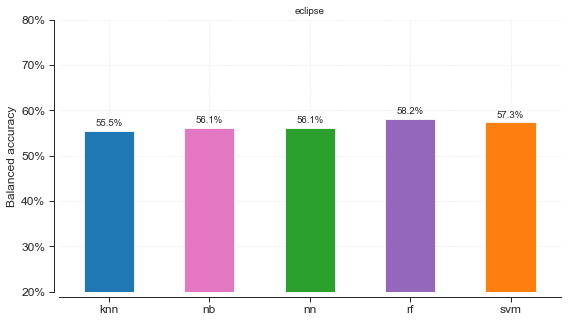

In [9]:
_=plot_bar(test_scores_bert, 'eclipse')

#### TF-IDF

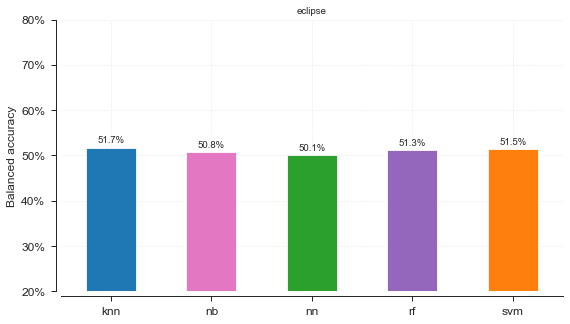

In [113]:
test_scores_tfidf = pd.read_csv('../../../data/metrics/feature-extraction/20210213_eclipse_feature_extraction_tfidf_test_scores.csv')
_=plot_bar(test_scores_tfidf, 'eclipse')

In [114]:
test_scores = pd.concat([test_scores_bert, test_scores_tfidf])

In [115]:
test_scores

,project,classifier,train_class_0,train_class_1,test_class_0,test_class_1,acc,balanced_acc,feature_extraction
0,eclipse,knn,3616,3539,1206,1179,0.555136,0.555378,bert
1,eclipse,nb,3616,3539,1206,1179,0.560587,0.560863,bert
2,eclipse,svm,3616,3539,1206,1179,0.573585,0.573212,bert
3,eclipse,rf,3616,3539,1206,1179,0.582390,0.581729,bert
4,eclipse,nn,3616,3539,1206,1179,0.561426,0.561274,bert
0,eclipse,knn,3659,3561,1220,1187,0.518072,0.517469,tf-idf
1,eclipse,nb,3659,3561,1220,1187,0.509348,0.508338,tf-idf
2,eclipse,svm,3659,3561,1220,1187,0.516410,0.514519,tf-idf
3,eclipse,rf,3659,3561,1220,1187,0.512671,0.512825,tf-idf
4,eclipse,nn,3659,3561,1220,1187,0.501039,0.500768,tf-idf


### BERT vs. TF-IDF

In [154]:

def get_colors():
    return np.array([
        [0.7, 0.7, 0.7],          
        [0.9, 0.9, 0.9],          
        [0.7, 0.7, 0.7],          
        [0.9, 0.9, 0.9],          
        [0.7, 0.7, 0.7],          
        [0.9, 0.9, 0.9],          
        [0.7, 0.7, 0.7],          
        [0.9, 0.9, 0.9],
        [0.984375, 0.7265625, 0],  # dark yellow
        [1, 1, 0.9]                # light yellow
    ])

def color_bars(axes, colors):
    for i in range(5):
        dark_color  = colors[i*2]
        light_color = colors[i*2 + 1]
        p1, p2 = axes[i].patches
        p1.set_color(dark_color)
        p2.set_color(light_color)
        p2.set_edgecolor(dark_color)
        p2.set_hatch('////')
        
def change_size(fig):
    fig.set_size_inches(8, 4)
    plt.tight_layout()
    
def make_labels(fig, axes):
    labels=["knn", "nb", "nn", "svm", "rf"]
    for i, ax in enumerate(axes):
        ax.set_xticks([-.2, .2])
        ax.set_xticklabels(["bert", "tf-idf"], fontdict={'fontsize':11})
        ax.set_xlabel(labels[i], fontsize = 11)
        ax.set_ylabel("")
        ax.set_title("")
        for p in ax.patches:
            width  = p.get_width()
            height = p.get_height()
            x, y   = p.get_xy() 
            ax.annotate(f'{height:.1%}', (x + width/2, y + height*1.02), ha='center')

        
    axes.flat[0].set_ylabel("balanced accuracy", fontsize = 11)
    
    
    ticks_loc = axes[0].get_yticks().tolist()
    axes[0].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[0].set_yticklabels(['{:.0f}%'.format(x*100) for x in axes[0].get_yticks()], 
                              fontdict={'fontsize':11})
    
    sns.despine(ax=axes[1], left=True)
    sns.despine(ax=axes[2], left=True)
    sns.despine(ax=axes[3], left=True)
    sns.despine(ax=axes[4], left=True)
    
    fig.suptitle("Long-lived bug prediction performance by feature extraction method")

def make_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Arial")
        
def plot_stacked_bar(data):
    g = sns.FacetGrid(
        data,
        col="classifier",
        col_order=["knn", "nb", "nn", "svm", "rf"],
        sharex=False
    )
    
    g.map(
        sns.barplot,
        "classifier", "balanced_acc", "feature_extraction",
        hue_order=["bert", "tf-idf"]
    )
    
    axes = np.array(g.axes.flat)
    for ax in axes:
        ax.hlines(0.5, -0.5, 0.5, linestyle='--', linewidth=1, color="black")
        ax.set_ylim(0, 0.6)
    
    return plt.gcf(), axes

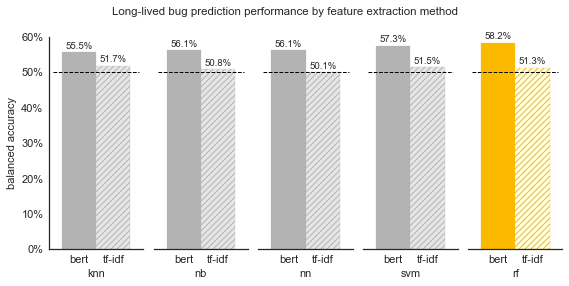

In [155]:
make_style()
fig, axes =plot_stacked_bar(test_scores)
make_labels(fig, axes)
change_size(fig)
color_bars(axes, get_colors())